In [1]:
__author__ = 'michaelrosenthal'

# import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
from time_TvsR import *
from matplotlib.colors import LogNorm
import os
import time

%matplotlib inline
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = (6,4)


In [16]:
def rate_odeint(m,t,p):

    alph,a_au,m_suns,temp,sig_gas,sig_p,st,verbose,verb_t = p
    
    cs = np.sqrt(fn.k*temp/fn.mu)
    vth = np.sqrt(8./np.pi)*cs
    om = np.sqrt(fn.G*m_suns*fn.m_sun/(a_au*fn.au)**3.)
    H_g = cs/om
    rho_g = sig_gas/2./H_g
    rho_s = 2.
    vk = a_au*fn.au*om
    v0 = cs**2./2./vk
    s = st_solver(st=st,alph=alph,a_au=a_au,sig_in = sig_gas,temp_in=temp,m_earths=m/fn.m_earth)
    
    rp = (3*m/4./np.pi/rho_s)**(1./3.)
    v_esc = np.sqrt(2*fn.G*m/rp)

    H_turb = np.sqrt(alph/(alph+st))*H_g
    H_KH = 2*v0/om
    H_p = max(H_turb,H_KH)
    rho_solid = sig_p/2./H_p
    v_turb = np.sqrt(alph)*cs/np.sqrt(1+st)
    v_lam = v0*np.sqrt(1+4.*st**2.)/(1+st**2.)
    v_inf = max(v_turb,v_lam)
    bGF = rp*(1+(v_esc/v_inf)**2.)**(0.5)
    H_acc = min(H_p,bGF)
    sig_acc = 4*bGF*H_acc
    rate_GF = rho_solid*sig_acc*v_inf
    
    m_earths = m/fn.m_earth
    rate_peb = TvsR_sng(alph=alph,a_au=a_au,m_suns=m_suns,r=s,m_earths=m_earths,temp_in=temp,\
                                   sig_g_in=sig_gas,sig_p_in=sig_p,out='rate')*fn.sec_to_years
    
    tmp,r_ws,h_r,b_r,b_shear = TvsR_sng(alph=alph,a_au=a_au,m_suns=m_suns,r=s,m_earths=m_earths,temp_in=temp,\
                                   sig_g_in=sig_gas,sig_p_in=sig_p,out='len')
    
    r_tmp = min(r_ws,b_shear)
    r_stab = min(r_tmp,h_r)
    
#     if r_stab < b_r:
#         return 0
    if bGF > r_stab:
        rate = rate_GF
    else:
        rate = rate_peb
#     rate = rate_peb + rate_GF
    if verbose:
#         print alph,a_au,m_suns,s,m_earths,temp,sig_gas,sig_p
        print(rate_peb, rate_GF)
#     elif verb_t:
#         print m/rate_peb, m/rate_GF
#     if m > 100*5.976e27: #100 earth masses
#         return 0
#     else:
    return rate

In [23]:
a_au = 0.5
M_dot = 1e-7
m_star = 1.
L_star = 3.
st = 1e-2

sig_gas_0 = 3000.
sig_gas = sig_gas_0*(a_au)**(-1.)

T_visc = 233.*(M_dot/1e-8)**(1./4.)*m_star**(1./4.)*(a_au)**(-1.)*(sig_gas_0/3000)**(1./4.) #From flow_iso_scratch notebook
T_irr = 150.*(L_star)**(2./7.)*m_star**(-1./7.)*a_au**(-3./7.)
T = max(T_visc,T_irr)

sig_p = 5.*a_au**(-1.)

a_cgs = a_au*fn.au
m_star_cgs = m_star*fn.m_sun

c_s = np.sqrt(fn.k*T/fn.mu)
om = np.sqrt(fn.G*m_star_cgs/a_cgs**3.)
vk = a_cgs*om
v_lam = c_s**2./2./vk
H = c_s/om

alpha = (M_dot*fn.m_sun/3.154e7)/(3*np.pi*sig_gas*c_s*H)

v_turb = np.sqrt(alpha)*c_s

v_gas = np.sqrt(v_lam**2. + v_turb**2.)
aspect = H/a_cgs

rho_g = sig_gas/2./H

mfp = fn.mu/rho_g/fn.cross

In [24]:
m0_arr = np.multiply([1e-3,1e-4,1e-5],fn.m_earth)
times = np.logspace(4,6.5,num=50000)/fn.sec_to_years

m_arr = np.zeros((len(m0_arr),len(times)))

for i,m0 in enumerate(m0_arr):
    p = [alpha,a_au,m_star,T,sig_gas,sig_p,st,1,0]
    wsol = odeint(rate_odeint,m0,times,args=(p,))
    m_arr[i] = wsol.flatten()

[8.79079608e+11] [1.42585733e+12]
[8.79087229e+11] [1.42587375e+12]
[8.79087229e+11] [1.42587375e+12]
[8.7909485e+11] [1.42589018e+12]
[8.7909485e+11] [1.42589018e+12]
[8.81816854e+11] [1.4317596e+12]
[8.81816868e+11] [1.43175963e+12]
[8.84550068e+11] [1.43765923e+12]
[8.84550096e+11] [1.43765929e+12]
[8.87294564e+11] [1.44358929e+12]
[8.87294593e+11] [1.44358935e+12]
[8.98107031e+11] [1.46701087e+12]
[8.98107224e+11] [1.46701129e+12]
[8.9546384e+11] [1.46127662e+12]
[8.95463949e+11] [1.46127685e+12]
[9.03733669e+11] [1.47923615e+12]
[9.03733576e+11] [1.47923595e+12]
[9.1210498e+11] [1.49747156e+12]
[9.12104991e+11] [1.49747159e+12]
[9.20579755e+11] [1.51598888e+12]
[9.20579767e+11] [1.51598891e+12]
[9.37845762e+11] [1.55388951e+12]
[9.37845821e+11] [1.55388964e+12]
[9.55544914e+11] [1.59298146e+12]
[9.55544892e+11] [1.59298141e+12]
[9.73690655e+11] [1.63330947e+12]
[9.73690635e+11] [1.63330942e+12]
[9.92297208e+11] [1.67492084e+12]
[9.92297216e+11] [1.67492086e+12]
[1.01137934e+12] [1

[8.35022021e+14] [1.40547945e+16]
[8.9583837e+14] [1.55132487e+16]
[8.95838516e+14] [1.55132522e+16]
[9.62742143e+14] [1.71658871e+16]
[9.6274233e+14] [1.71658918e+16]
[1.0365183e+15] [1.90445743e+16]
[1.03651854e+15] [1.90445803e+16]
[1.11807718e+15] [2.06516658e+16]
[1.11736185e+15] [2.06423611e+16]
[1.11734942e+15] [2.06421994e+16]
[1.08383408e+15] [2.02043171e+16]
[1.08377115e+15] [2.02034913e+16]
[1.04575681e+15] [1.92838758e+16]
[1.04575681e+15] [1.92838759e+16]
[1.05510582e+15] [1.95269415e+16]
[1.05510582e+15] [1.95269415e+16]
[1.06456723e+15] [1.97738488e+16]
[1.06456724e+15] [1.97738488e+16]
[1.07414277e+15] [2.0024671e+16]
[1.07414277e+15] [2.0024671e+16]
[1.08383414e+15] [2.02043179e+16]
[1.08382059e+15] [2.020414e+16]
[1.08383414e+15] [2.02043178e+16]
[1.08381909e+15] [2.02041203e+16]
[1.07607172e+15] [2.00753117e+16]
[1.07607172e+15] [2.00753118e+16]
[1.07800531e+15] [2.01261126e+16]
[1.07800532e+15] [2.01261128e+16]
[1.07994358e+15] [2.01532389e+16]
[1.07994244e+15] [2.0

[1.74681188e+12] [3.55299725e+12]
[1.87798818e+12] [3.91231666e+12]
[1.87798844e+12] [3.9123174e+12]
[2.02260359e+12] [4.31820807e+12]
[2.02260394e+12] [4.31820906e+12]
[2.18242314e+12] [4.77810458e+12]
[2.18242359e+12] [4.77810588e+12]
[2.35949773e+12] [5.3008616e+12]
[2.35949829e+12] [5.30086329e+12]
[2.5562193e+12] [5.89707567e+12]
[2.55622003e+12] [5.89707789e+12]
[2.77538897e+12] [6.57948707e+12]
[2.7753899e+12] [6.57949e+12]
[2.73474186e+12] [6.45152717e+12]
[2.73474234e+12] [6.45152868e+12]
[2.9302524e+12] [7.07267622e+12]
[2.93025255e+12] [7.07267668e+12]
[3.14481906e+12] [7.7703827e+12]
[3.14481955e+12] [7.77038433e+12]
[3.38082174e+12] [8.55625678e+12]
[3.38082222e+12] [8.55625839e+12]
[3.64100409e+12] [9.44400895e+12]
[3.64100472e+12] [9.44401112e+12]
[3.92854302e+12] [1.04499056e+13]
[3.92854382e+12] [1.04499085e+13]
[4.24712949e+12] [1.15933248e+13]
[4.2471305e+12] [1.15933285e+13]
[4.60106846e+12] [1.28974556e+13]
[4.60106977e+12] [1.28974605e+13]
[4.99540152e+12] [1.4390

[8.7907961e+09] [3.50856541e+09]
[8.79084309e+09] [3.50858878e+09]
[8.79084309e+09] [3.50858878e+09]
[8.79089007e+09] [3.50861215e+09]
[8.79089007e+09] [3.50861215e+09]
[8.82629951e+09] [3.52623614e+09]
[8.82629966e+09] [3.52623621e+09]
[8.86185158e+09] [3.54395154e+09]
[8.86185187e+09] [3.54395169e+09]
[8.897547e+09] [3.5617589e+09]
[8.89754729e+09] [3.56175905e+09]
[9.05438598e+09] [3.64024367e+09]
[9.05438833e+09] [3.64024484e+09]
[9.01036617e+09] [3.61817569e+09]
[9.01036737e+09] [3.61817629e+09]
[9.12461934e+09] [3.67551691e+09]
[9.12461826e+09] [3.67551637e+09]
[9.24031773e+09] [3.73379445e+09]
[9.24031782e+09] [3.7337945e+09]
[9.35748436e+09] [3.79302626e+09]
[9.35748446e+09] [3.79302631e+09]
[9.59629307e+09] [3.91441446e+09]
[9.59629354e+09] [3.9144147e+09]
[9.84119736e+09] [4.03981186e+09]
[9.84119716e+09] [4.03981176e+09]
[1.00923511e+10] [4.16935222e+09]
[1.00923509e+10] [4.16935212e+09]
[1.03499142e+10] [4.30317494e+09]
[1.03499143e+10] [4.30317496e+09]
[1.06140508e+10] [4.

[7.77970793e+12] [2.59625634e+13]
[7.77970952e+12] [2.59625705e+13]
[8.54639111e+12] [2.94259604e+13]
[8.54639253e+12] [2.94259669e+13]
[9.41712602e+12] [3.34865132e+13]
[9.41712819e+12] [3.34865235e+13]
[1.04101787e+13] [3.82721448e+13]
[1.04101818e+13] [3.82721601e+13]
[1.1547801e+13] [4.39439158e+13]
[1.15478052e+13] [4.39439372e+13]
[1.13441157e+13] [4.29141358e+13]
[1.13441179e+13] [4.29141469e+13]
[1.23931133e+13] [4.82816333e+13]
[1.23931137e+13] [4.82816355e+13]
[1.35754427e+13] [5.45150237e+13]
[1.35754455e+13] [5.45150386e+13]
[1.49129846e+13] [6.17875109e+13]
[1.49129871e+13] [6.17875246e+13]
[1.64320592e+13] [7.03140195e+13]
[1.6432063e+13] [7.03140411e+13]
[1.8164537e+13] [8.0363215e+13]
[1.81645424e+13] [8.03632471e+13]
[2.01492434e+13] [9.22733672e+13]
[2.01492508e+13] [9.22734122e+13]
[1.97937996e+13] [9.01103639e+13]
[1.97938035e+13] [9.01103872e+13]
[2.16237869e+13] [1.0138098e+14]
[2.16237877e+13] [1.01380984e+14]
[2.36863743e+13] [1.14469873e+14]
[2.36863792e+13] [1

No handles with labels found to put in legend.


(1e-06, 200.0)

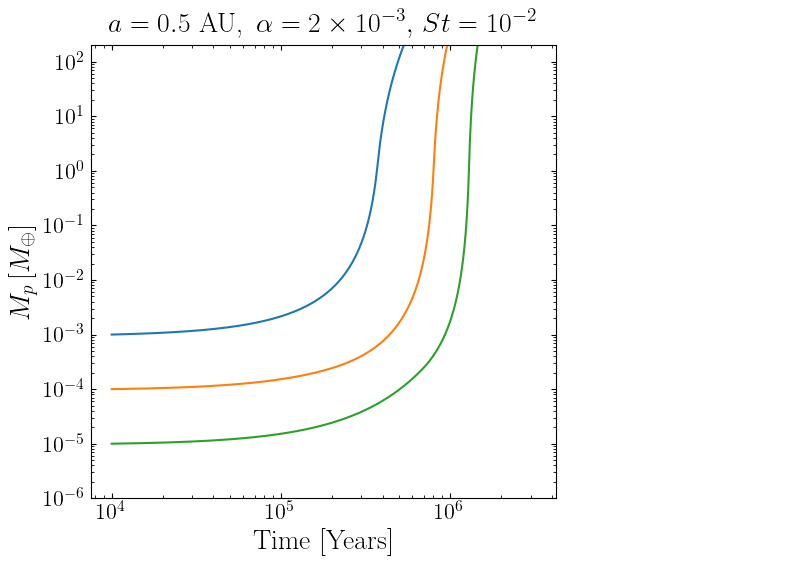

In [25]:
fig = plt.figure(figsize=(6,6))

# labels = [r'$M_0 = 10^{-7} M_\oplus$',r'$M_0 = 10^{-6} M_\oplus$',r'$M_0 = 10^{-5} M_\oplus$']

for i in range(len(m0_arr)):
    plt.loglog(times*fn.sec_to_years,m_arr[i]/fn.m_earth)
    
# plt.ylim([1e-8,1e2])
plt.xlabel('Time [Years]',fontsize=20)
plt.ylabel(r'$M_p \, [M_\oplus]$',fontsize=20)

# plt.axhline(y=1e1,linestyle='dashed',color='#' + colors[-1])

lgd = plt.gca().legend(bbox_to_anchor=[1.55,0.70],frameon=False)

plt.title(r'$a = 0.5$ AU,\, $\alpha = 2 \times 10^{-3}, \, St = 10^{-2}$',y=1.01)
plt.ylim(1e-6,2e2)
# plt.tight_layout()

In [6]:
fig.savefig('M_vs_t.pdf',bbox_inches='tight')